In [150]:
import glob
import os
from aic_domain.tool_handover_v2.agent import NurseAgent, SurgeonAgent, PerfusionAgent, AnesthesiaAgent
from aic_domain.tool_handover_v2.simulator import ToolHandoverV2Simulator
from aic_domain.tool_handover_v2.mdp import MDP_ToolHandover_V2
from aic_domain.tool_handover_v2.nurse_mdp import MDP_THO_Nurse, THONursePolicy
from aic_domain.tool_handover_v2.surgery_info import CABG_INFO
from aic_domain.tool_handover_v2.utils import ToolHandoverV2Trajectories
from aic_domain.tool_handover_v2.define import PatientVital
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


width = CABG_INFO["width"]
height = CABG_INFO["height"]

num_training_data = 10000

TEMPERATURE = 0.3
# nurse_agent = InteractiveAgent()
nurse_mdp = MDP_THO_Nurse(**CABG_INFO)
nurse_policy = THONursePolicy(nurse_mdp, TEMPERATURE)

# Setting this variable False will emulate a novice nurse
EXPERIENCED_NURSE = True
nurse_agent = NurseAgent(nurse_policy, EXPERIENCED_NURSE)

surgeon_agent = SurgeonAgent(CABG_INFO["surgeon_pos"])
anes_agent = AnesthesiaAgent()
perf_agent = PerfusionAgent()

mdp = MDP_ToolHandover_V2(**CABG_INFO)
game = ToolHandoverV2Simulator()

def conv_latent_to_idx(latent):
    return nurse_policy.conv_latent_to_idx(latent)

train_data = ToolHandoverV2Trajectories(
    MDP_ToolHandover_V2,
    (1, 4, 1),
    conv_latent_to_idx)

game.init_game(mdp)
game.set_autonomous_agent(nurse_agent=nurse_agent,
                        surgeon_agent=surgeon_agent,
                        anes_agent=anes_agent,
                        perf_agent=perf_agent)

DATA_DIR = os.path.join(os.path.realpath("."), "data")
SEQ_DIR = os.path.join(DATA_DIR, 'encoded')

prefix = "seq_"
print(SEQ_DIR)

100%|██████████| 3456/3456 [00:00<00:00, 1152083.50it/s]

C:\Users\Windows\Documents\Coding\unhelkarlab\ai-coach\analysis\MLPL_results\data\encoded


In [168]:
file_names = glob.glob(os.path.join(SEQ_DIR, prefix + '*.txt'))
# random.shuffle(file_names)
num_train = min(num_training_data, len(file_names))

seq_files = file_names[:num_train]

seqs = []
for idx, sf in enumerate(seq_files):
    seqs.append(game.read_file(sf, mdp, nurse_agent))
np.save('seqs.npy', np.array(seqs, dtype='object'))

In [169]:
seqs = np.load('seqs.npy', allow_pickle=True)

In [153]:
seqs[9999]

[[(<PatientVital.Stable: 0>,
   <NurseDirection.Down: 2>,
   (2, 3),
   <Requirement.Hand_Only: 1>,
   <Requirement.Hand_Only: 1>,
   False,
   False,
   False,
   0,
   <Requirement.Antiseptic_Solution: 2>,
   False),
  ((<NurseAction.Rotate_180: 3>, None),
   <SurgeonAction.Exchange_Tool: 2>,
   <AnesthesiaAction.Proceed: 1>,
   <PerfusionAction.Proceed: 1>),
  <Requirement.Antiseptic_Solution: 2>],
 [(<PatientVital.Stable: 0>,
   <NurseDirection.Up: 0>,
   (2, 3),
   <Requirement.Hand_Only: 1>,
   <Requirement.Hand_Only: 1>,
   False,
   True,
   True,
   0,
   <Requirement.Antiseptic_Solution: 2>,
   False),
  ((<NurseAction.Move_Forward: 4>, None),
   <SurgeonAction.Stay: 0>,
   <AnesthesiaAction.Stay: 0>,
   <PerfusionAction.Stay: 0>),
  <Requirement.Antiseptic_Solution: 2>],
 [(<PatientVital.Stable: 0>,
   <NurseDirection.Up: 0>,
   (2, 2),
   <Requirement.Hand_Only: 1>,
   <Requirement.Hand_Only: 1>,
   False,
   True,
   True,
   0,
   <Requirement.Antiseptic_Solution: 2>,
   

Mean: 170.7168
Median: 163.0
Standard Deviation: 33.40840310101636
Variance: 1116.1213977599998
Minimum: 108
Maximum: 350
Range: 242
Mean: 234.301
Median: 237.0
Standard Deviation: 38.29175889143772
Variance: 1466.258799
Minimum: 113
Maximum: 347
Range: 234


(array([ 287., 1634., 1678.,  749.,  278.,  203.,  114.,   36.,   14.,
           7.]),
 array([108. , 132.2, 156.4, 180.6, 204.8, 229. , 253.2, 277.4, 301.6,
        325.8, 350. ]),
 <BarContainer object of 10 artists>)

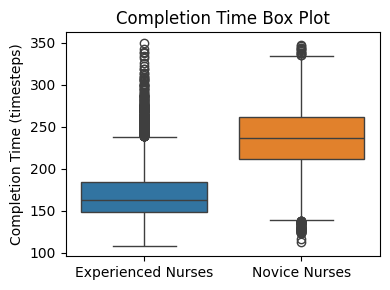

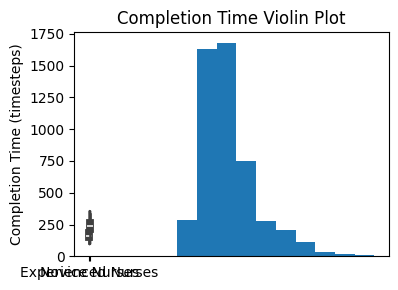

In [188]:
exp, nov = [], []
for idx, seq in enumerate(seqs):
    time = len(seq) - 1
    if idx < 5000: exp.append(time)
    else: nov.append(time)
    # print(idx, time)

labels = ['Experienced Nurses', 'Novice Nurses']

plt.figure(figsize=(4, 3))
sns.boxplot(data={'Experienced Nurses': exp, 'Novice Nurses': nov})
plt.ylabel('Completion Time (timesteps)')
plt.title('Completion Time Box Plot')
plt.tight_layout()
plt.savefig('boxplots.png')

plt.figure(figsize=(4, 3))
sns.violinplot(data={'Experienced Nurses': exp, 'Novice Nurses': nov})
plt.ylabel('Completion Time (timesteps)')
plt.title('Completion Time Violin Plot')
plt.tight_layout()
plt.savefig('violinplots.png')

def summary(data):
    mean = np.mean(data)  # Mean
    median = np.median(data)  # Median
    std_dev = np.std(data)  # Standard Deviation
    variance = np.var(data)  # Variance
    min_val = np.min(data)  # Minimum
    max_val = np.max(data)  # Maximum
    range_val = np.ptp(data)  # Range (maximum - minimum)

    # Print the summary statistics
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Variance: {variance}")
    print(f"Minimum: {min_val}")
    print(f"Maximum: {max_val}")
    print(f"Range: {range_val}")

summary(exp)
summary(nov)

plt.hist(exp)


In [174]:
# Step 4: Test for Equality of Variances
from scipy import stats


# Step 1: Perform the Mann-Whitney U Test (Wilcoxon rank-sum test)
_, p_value = stats.mannwhitneyu(exp, nov, alternative="two-sided")
print(stats.mannwhitneyu(exp, nov, alternative="two-sided"))

# Step 2: Interpret the Results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in completion times.")
else:
    print("Fail to reject the null hypothesis. No significant difference in completion times.")

MannwhitneyuResult(statistic=2859841.0, pvalue=0.0)
Reject the null hypothesis. There is a significant difference in completion times.


[[13.4034  0.    ]
 [ 5.294   0.647 ]
 [14.427   1.137 ]
 [14.6954  1.191 ]
 [16.62    1.3484]
 [11.0698  0.8974]
 [12.1894  0.9028]
 [12.0004  0.9364]
 [19.184   1.7276]
 [12.4068  0.9834]
 [ 9.7554  0.6536]
 [ 7.9414  0.52  ]
 [11.0404  0.7448]]
[[20.0410082   0.        ]
 [ 9.84116823  1.42728546]
 [18.85857171  1.5975195 ]
 [18.77015403  1.52410482]
 [19.50410082  1.66893379]
 [13.29165833  1.03540708]
 [16.80816163  1.27805561]
 [16.65373075  1.26085217]
 [23.14502901  1.82596519]
 [17.12582517  1.32566513]
 [17.89557912  1.40128026]
 [11.22124425  0.84476895]
 [15.85937187  1.0980196 ]]


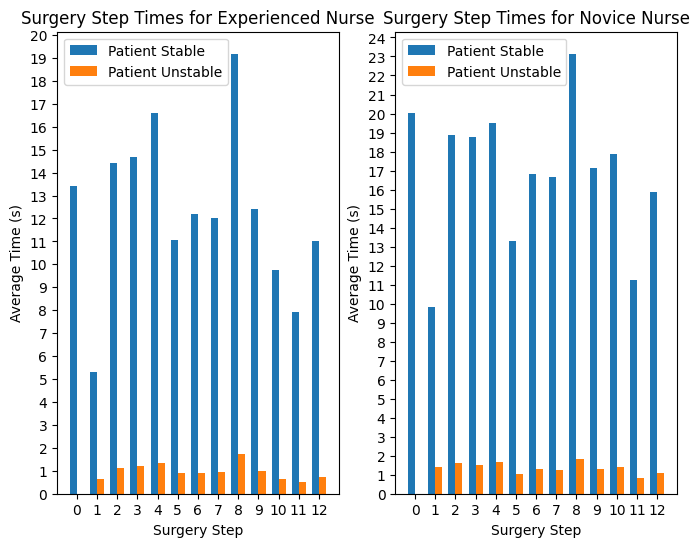

In [179]:
def task_times(seq):
    # steps
    freq = np.zeros((13, 2))
    # iterate over each entry of sequence 0
    for entry in seq:
        # unpack entry[0], the state
        (patient_vital, nurse_dir, nurse_pos, nurse_tool, surgeon_tool, surgeon_ready, perf_ready, anes_ready,
        cur_step, cur_requirement,
        nurse_asked) = entry[0]
        if patient_vital == PatientVital.Stable: freq[cur_step,0] += 1
        else: freq[cur_step,1] += 1
        
    # stable = np.array(arr, dtype='object') == PatientVital.Stable
    # print(stable)
    # [(key, sum(1 for _ in group)) for key, group in itertools.groupby(stable)]
    return freq

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))
def hist_tt(exp, ax):
    tt = np.stack([task_times(seqs[i]) for i in (range(5000,9999) if exp == "novice" else range(5000))], axis=0)
    mean, std = np.mean(tt, axis=0), np.std(tt, axis=0)
    print(mean)

    # Create an array of indices for the x-axis (group positions)
    x = np.arange(13)
    # Define the width of the bars
    bar_width = 0.35
    # Plot the bars for the first group
    bar1 = ax.bar(x - bar_width/2, mean[:, 0], bar_width, label='Patient Stable')
    # Plot the bars for the second group
    bar2 = ax.bar(x + bar_width/2, mean[:, 1], bar_width, label='Patient Unstable')
    # Add labels and title
    ax.set_xlabel('Surgery Step')
    ax.set_ylabel('Average Time (s)')
    ax.set_title(f'Surgery Step Times for {"Novice" if exp == "novice" else "Experienced"} Nurse')
    ax.set_xticks(x)
    max_value = np.max(mean)
    ax.set_yticks(np.arange(0, max_value + 1, 1))
    ax.legend()
    # Show the plot

    # bin_width = 1
    # data = exp_tt[:,7,0]
    # min_value = np.min(data)
    # max_value = np.max(data)
    # num_bins = int(np.ceil((max_value - min_value) / bin_width))
    # plt.hist(data, bins=num_bins)

hist_tt("exp", ax1)
hist_tt("novice", ax2)
plt.show()

[[13.4034  0.    ]
 [ 5.294   0.647 ]
 [14.427   1.137 ]
 [14.6954  1.191 ]
 [16.62    1.3484]
 [11.0698  0.8974]
 [12.1894  0.9028]
 [12.0004  0.9364]
 [19.184   1.7276]
 [12.4068  0.9834]
 [ 9.7554  0.6536]
 [ 7.9414  0.52  ]
 [11.0404  0.7448]] [[20.0410082   0.        ]
 [ 9.84116823  1.42728546]
 [18.85857171  1.5975195 ]
 [18.77015403  1.52410482]
 [19.50410082  1.66893379]
 [13.29165833  1.03540708]
 [16.80816163  1.27805561]
 [16.65373075  1.26085217]
 [23.14502901  1.82596519]
 [17.12582517  1.32566513]
 [17.89557912  1.40128026]
 [11.22124425  0.84476895]
 [15.85937187  1.0980196 ]]
[0.33120131 0.46205574 0.23498979 0.21708687 0.14787151 0.16716186
 0.27479279 0.27941672 0.17113951 0.27555024 0.45487095 0.29228882
 0.30385641]
[       nan 0.54669194 0.2882716  0.21855768 0.19205902 0.13328775
 0.29361446 0.25732769 0.05387025 0.2581837  0.53356939 0.38444708
 0.32168788]


C:\Users\Windows\AppData\Local\Temp\ipykernel_20536\1180719299.py:7: RuntimeWarning: invalid value encountered in true_divide
  print((nov_mean[:,1]-exp_mean[:,1])/nov_mean[:, 1])


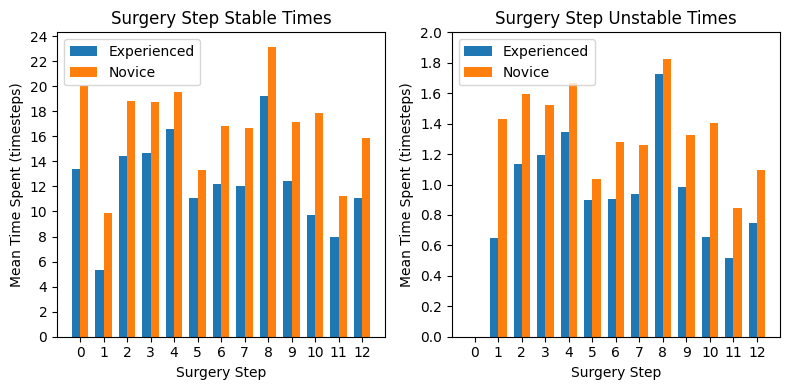

In [195]:
exp_tt = np.stack([task_times(seqs[i]) for i in range(5000)], axis=0)
nov_tt = np.stack([task_times(seqs[i]) for i in range(5000,9999)], axis=0)
exp_mean, nov_mean = np.mean(exp_tt, axis=0), np.mean(nov_tt, axis=0)

print(exp_mean, nov_mean)
print((nov_mean[:,0]-exp_mean[:,0])/nov_mean[:, 0])
print((nov_mean[:,1]-exp_mean[:,1])/nov_mean[:, 1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
def bar_vital(status, ax):
    # Create an array of indices for the x-axis (group positions)
    x = np.arange(13)
    # Define the width of the bars
    bar_width = 0.35
    # Plot the bars for the first group
    bar1 = ax.bar(x - bar_width/2, exp_mean[:, 0 if status else 1], bar_width, label='Experienced')
    # Plot the bars for the second group
    bar2 = ax.bar(x + bar_width/2, nov_mean[:, 0 if status else 1], bar_width, label='Novice')
    # Add labels and title
    ax.set_xlabel('Surgery Step')
    ax.set_ylabel('Mean Time Spent (timesteps)')
    ax.set_title(f'Surgery Step {"Stable" if status else "Unstable"} Times')
    ax.set_xticks(x)
    max_value = np.max([np.max(exp_mean[:,0 if status else 1]),np.max(nov_mean[:,0 if status else 1])])
    ax.set_yticks(np.arange(0, max_value + 1, 2))
    if not status: ax.set_yticks(np.arange(0, 2.2, 0.2))
    ax.legend()
    # Show the plot

    # bin_width = 1
    # data = exp_tt[:,7,0]
    # min_value = np.min(data)
    # max_value = np.max(data)
    # num_bins = int(np.ceil((max_value - min_value) / bin_width))
    # plt.hist(data, bins=num_bins)

bar_vital(True, ax1)
bar_vital(False, ax2)
plt.tight_layout()
plt.savefig("steptimes.png")

In [204]:
from aic_domain.tool_handover_v2.define import NurseAction

for entry in seqs[0]:
    # unpack entry[0], the state
    (patient_vital, nurse_dir, nurse_pos, nurse_tool, surgeon_tool, surgeon_ready, perf_ready, anes_ready,
    cur_step, cur_requirement,
    nurse_asked) = entry[0]
    if len(entry) == 1: break
    nurse_act, surgeon_act, anes_act, perf_act = entry[1]
    latent = entry[2]

    print(patient_vital, cur_requirement, latent, nurse_act[0], surgeon_act)

PatientVital.Stable Requirement.Antiseptic_Solution Requirement.Antiseptic_Solution NurseAction.Ask_Requirement SurgeonAction.Exchange_Tool
PatientVital.Stable Requirement.Antiseptic_Solution Requirement.Antiseptic_Solution NurseAction.Rotate_180 SurgeonAction.Tell_Requirement
PatientVital.Stable Requirement.Antiseptic_Solution Requirement.Antiseptic_Solution NurseAction.Move_Forward SurgeonAction.Stay
PatientVital.Stable Requirement.Antiseptic_Solution Requirement.Antiseptic_Solution NurseAction.Move_Forward SurgeonAction.Stay
PatientVital.Stable Requirement.Antiseptic_Solution Requirement.Antiseptic_Solution NurseAction.Rotate_Left SurgeonAction.Stay
PatientVital.Stable Requirement.Antiseptic_Solution Requirement.Antiseptic_Solution NurseAction.PickUp_Drop SurgeonAction.Stay
PatientVital.Stable Requirement.Antiseptic_Solution Requirement.Antiseptic_Solution NurseAction.Rotate_Left SurgeonAction.Stay
PatientVital.Stable Requirement.Antiseptic_Solution Requirement.Antiseptic_Solution N

In [237]:
from aic_domain.tool_handover_v2.define import NurseAction

X_EXP = []
for seq in seqs[0:5000]:
    cnt = 0
    move_step = np.zeros((13,))
    asks = 0
    for entry in seq:
        # unpack entry[0], the state
        (patient_vital, nurse_dir, nurse_pos, nurse_tool, surgeon_tool, surgeon_ready, perf_ready, anes_ready,
        cur_step, cur_requirement,
        nurse_asked) = entry[0]
        if len(entry) == 1: break
        nurse_act, surgeon_act, anes_act, perf_act = entry[1]
        latent = entry[2]

        if nurse_act[0] in [NurseAction.Move_Forward, NurseAction.Rotate_180, NurseAction.Rotate_Left, NurseAction.Rotate_Right]:
            move_step[cur_step] += 1
        if cur_requirement != latent: cnt += 1
        if nurse_act[0] == NurseAction.Ask_Requirement: asks += 1

    X_EXP.append((cnt, np.mean(move_step), asks))

X_NOV = []
for seq in seqs[0:5000]:
    cnt = 0
    move_step = np.zeros((13,))
    asks = 0
    for entry in seq:
        # unpack entry[0], the state
        (patient_vital, nurse_dir, nurse_pos, nurse_tool, surgeon_tool, surgeon_ready, perf_ready, anes_ready,
        cur_step, cur_requirement,
        nurse_asked) = entry[0]
        if len(entry) == 1: break
        nurse_act, surgeon_act, anes_act, perf_act = entry[1]
        latent = entry[2]

        if nurse_act[0] in [NurseAction.Move_Forward, NurseAction.Rotate_180, NurseAction.Rotate_Left, NurseAction.Rotate_Right]:
            move_step[cur_step] += 1
        if cur_requirement != latent: cnt += 1
        if nurse_act[0] == NurseAction.Ask_Requirement: asks += 1

    X_NOV.append((cnt, np.mean(move_step), asks))

X_NOV = np.array(X_NOV)
X_EXP = np.array(X_EXP)

In [238]:
import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame 'df' containing your data
# 'df' should include columns for task completion times, as well as other relevant variables

# Define your dependent variable (task completion times) and independent variables
  # Replace 'CompletionTime' with the actual column name
  # Replace with your independent variables

def ols(X_in, y):
  # Add a constant term to the independent variables
  X_in = sm.add_constant(X_in)

  # Fit the multivariable regression model
  model = sm.OLS(y, X_in).fit()

  # Get a summary of the regression results
  summary = model.summary()

  # Print the summary, including p-values and other statistics
  print(summary)

ols(X_EXP, exp)
ols(X_EXP, nov)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 4.566e+04
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:50:22   Log-Likelihood:                -16271.
No. Observations:                5000   AIC:                         3.255e+04
Df Residuals:                    4996   BIC:                         3.258e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.6594      0.576     47.993      0.0

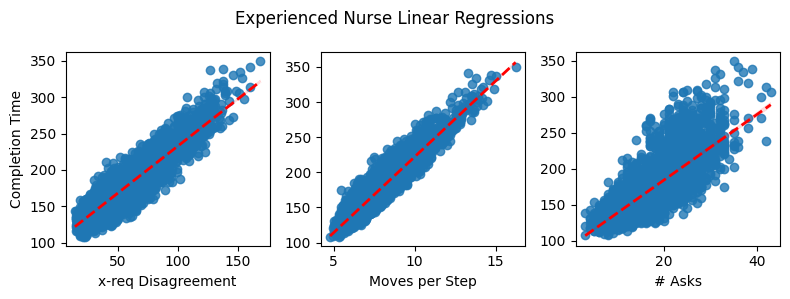

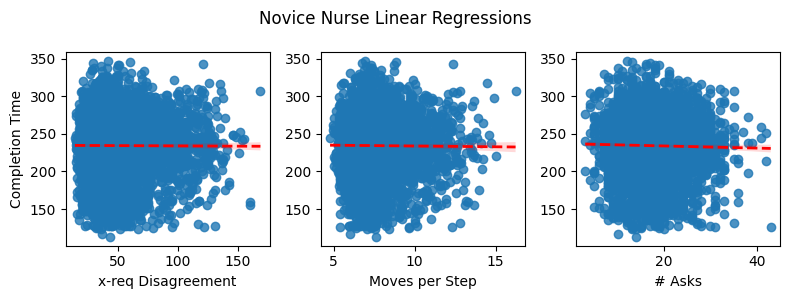

In [248]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(8,3))
sns.regplot(x=X_EXP[:,0], y=exp, ax=ax1, line_kws={"color": "red", "linewidth": 2, "linestyle": "--"})
ax1.set_xlabel('x-req Disagreement')
ax1.set_ylabel('Completion Time')
sns.regplot(x=X_EXP[:,1], y=exp, ax=ax2, line_kws={"color": "red", "linewidth": 2, "linestyle": "--"})
ax2.set_xlabel('Moves per Step')
sns.regplot(x=X_EXP[:,2], y=exp, ax=ax3, line_kws={"color": "red", "linewidth": 2, "linestyle": "--"})
ax3.set_xlabel('# Asks')
fig.suptitle("Experienced Nurse Linear Regressions")
plt.tight_layout()
plt.savefig("linregEXP.png")

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(8,3))
sns.regplot(x=X_NOV[:,0], y=nov, ax=ax1, line_kws={"color": "red", "linewidth": 2, "linestyle": "--"})
ax1.set_xlabel('x-req Disagreement')
ax1.set_ylabel('Completion Time')
sns.regplot(x=X_NOV[:,1], y=nov, ax=ax2, line_kws={"color": "red", "linewidth": 2, "linestyle": "--"})
ax2.set_xlabel('Moves per Step')
sns.regplot(x=X_NOV[:,2], y=nov, ax=ax3, line_kws={"color": "red", "linewidth": 2, "linestyle": "--"})
ax3.set_xlabel('# Asks')
fig.suptitle("Novice Nurse Linear Regressions")
plt.tight_layout()
plt.savefig("linregNOV.png")